In [1]:
"""
Notebook for training the individual spot classifier

That is frozen and used in the bloodspot_card_classifier notebook
"""

'\nNotebook for training the individual spot classifier\n\nThat is frozen and used in the bloodspot_card_classifier notebook\n'

In [2]:
import os
import torch
import numpy as np
from torchvision import transforms
from torch.utils.data import Dataset
from torchvision.io import ImageReadMode
from PIL import Image
import torchvision.transforms.functional as fn
import matplotlib.pyplot as plt
import pandas as pd
from torchvision.io import read_image
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.optim.lr_scheduler import StepLR
import cv2
from statistics import mean
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from sklearn.metrics import f1_score
from tqdm import tqdm
from time import sleep
from termcolor import colored

In [3]:
#connecting to google drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
#connecting to GPU if available
#to use gpu (RAM/Disk dropdown > Change runtime type > Hardware Accelerator > GPU > Save)
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
device

device(type='cpu')

In [5]:
## add your path to the bloodspot google drive here
#noah:
train_data_path = '/content/drive/MyDrive/Blood Spot/Data/individual_spot_fake_data/train'
test_data_path = '/content/drive/MyDrive/Blood Spot/Data/individual_spot_fake_data/test'
#base directory
test_train_path = '/content/drive/MyDrive/Blood Spot/Data/individual_spot_fake_data'

In [6]:
# Find means and stds for normalize transformation
"""
hard coded in with current data, but uncomment if you need those numbers 
**takes a few minutes to run
"""

# means = np.array([0, 0, 0], dtype=np.float32)
# stds = np.array([0, 0, 0], dtype=np.float32)
# total_images = 0
# all_files = []

# for root, _, files in os.walk(train_data_path, topdown=False):
#   for name in files:
#     all_files.append(os.path.join(root, name))

# for f in all_files:
#     img = cv2.imread(f)
#     means += img.mean(axis=(0,1))
#     stds += img.std(axis=(0,1))
#     total_images += 1

# means = means / (total_images * 255.)
# stds = stds / (total_images * 255.)
# print("Total images: ", total_images)
# print("Means: ", means)
# print("Stds: ", stds)

In [7]:
#Class object used in IndividualBloodSpotDataset Dataloader
class PictureObject():
  def __init__(self, label, path):
    self.name = path
    self.dictionary = {'label': label,
                       'path': path}
  def __repr__(self):
    return self.name
  def get_path(self):
    return self.dictionary['path']
  def get_label(self):
    label = self.dictionary['label']
    if label == 'good':
      return 0
    if label == 'bad':
      return 1

In [8]:
## labels: (1 is bad, 0 is good)
"""
Steps for dataloader:
1. init
    1. define variables
    2. using directory passed, walk through it and create a list PictureObjects where each
    PictureObject corresponds to one spot
2. getitem
    1. using the index get the PictureObject at that position in the list
    2. get path and label of the spot using the class
    3. apply transformations

"""

class IndividualBloodSpotDataset(Dataset):

  def __init__(self, train_data_path,transform=None, size= [255,255]):
    self.transform = transform
    self.size = size
    self.pictureObjects = []
    #walk through base dir
    for root, _, files in os.walk(train_data_path, topdown=False):
      for name in files:
        dirs = os.path.join(root, name).replace(train_data_path+'/','').split('/')
        self.pictureObjects.append(PictureObject(dirs[0],os.path.join(root, name)))

  def __len__(self):
    return len(self.pictureObjects)
  
  def __getitem__(self, ix):
    #get path/label with key_list
    path = self.pictureObjects[ix].get_path()
    label = self.pictureObjects[ix].get_label()

    #reads in image and resizes the image to size parameter
    img = read_image(path, mode = ImageReadMode.RGB)
    img = fn.resize(img, size=self.size)

    #read and resize images from image path dictionary then stack the tensors into 4 dimensional tensor
    if self.transform:
      img = self.transform(img)

    label = torch.Tensor([label]).type(torch.float)

    return img, label

In [9]:
#transforms
train_transform = transforms.Compose([
    transforms.ConvertImageDtype(torch.float32),
    transforms.RandomPerspective(distortion_scale=0.2, p=0.4),
    transforms.RandomRotation(360),
    transforms.RandomApply(torch.nn.ModuleList([transforms.GaussianBlur(5, sigma=(0.1, 2.0))]), p=0.4),# how to choose sigma
    transforms.RandomApply(torch.nn.ModuleList([transforms.ColorJitter(brightness=0.5, contrast=0.0, saturation=0.0, hue=0)]), p = 0.2),
    transforms.Normalize(mean = [0.52621067, 0.5534213, 0.6714008], std = [0.2764587, 0.2725054, 0.18896917])
     ])

test_transform = transforms.Compose([
    transforms.ConvertImageDtype(torch.float32),
    transforms.Normalize(mean = [0.52621067, 0.5534213, 0.6714008], std = [0.2764587, 0.2725054, 0.18896917])
     ])

In [10]:
#instantiate dataset class objects
train_data = IndividualBloodSpotDataset(train_data_path, transform=train_transform)
test_data = IndividualBloodSpotDataset(test_data_path, transform=test_transform)

In [11]:
print('shape:  '+str(train_data.__getitem__(0)[0].shape))
print('label:  '+str(train_data.__getitem__(0)[1]))

shape:  torch.Size([3, 255, 255])
label:  tensor([0.])


In [12]:
#instantiating dataloader
train_dataloader = torch.utils.data.DataLoader(dataset=train_data,
                                               batch_size=5, 
                                               shuffle=True,
                                               num_workers=1)

test_loader = torch.utils.data.DataLoader(dataset=test_data,
                                               batch_size=5,
                                               shuffle=True,
                                               num_workers=1)

In [13]:
#sizes
train_features, train_labels = next(iter(train_dataloader))
print(f"Feature batch shape: {train_features.size()}")
print(f"Labels batch shape: {train_labels.size()}")

Feature batch shape: torch.Size([5, 3, 255, 255])
Labels batch shape: torch.Size([5, 1])


torch.Size([3, 255, 255])


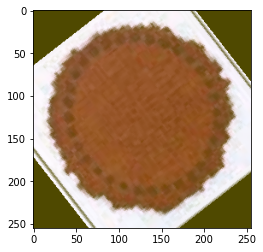

In [14]:
#printing image
img = train_features[4]
print(img.size())
label = train_labels
img = (img - img.min())/(img.max() - img.min())
plt.imshow(img.permute(1, 2, 0))
plt.show()

In [15]:
"""
  steps in individidual spot network (Net)
  1. apply three ConvBlock operations to the input images using the ConvBlock Class
    Steps for the ConvBlock operations
    1. apply 2d convolution
    2. apply batch normalization
    3. apply Relu activation function unless otherwise passed when instantiating the object
    4. apply dropout
    5. apply maxpooling

  2. flatten the images

  3. apply a fully connected layer
"""
class ConvBlock(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size, dropout_rate=0.1, activation_func = nn.ReLU):
        super(ConvBlock, self).__init__()

        self.block = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size),
            nn.BatchNorm2d(out_channels),
            activation_func(),
            nn.Dropout(dropout_rate),
            nn.MaxPool2d(2)
        )

    def forward(self, x):
        return self.block(x)

class Net(nn.Module):

    def __init__(self): # sequential 

        super(Net, self).__init__()
        # 3 input image channels, 6 output channels, 5x5 square convolution
        # kernel

        self.operation1 = ConvBlock(3,5,3,0.1)
        self.operation2 = ConvBlock(5,10,3,0.1)
        self.operation3 = ConvBlock(10,10,3,0.4)

        # an affine operation: y = Wx + b
        #How do I know 29*29
        self.fc1 = nn.Linear(10 * 30 * 30, 1)

    def forward(self, x):

        x = self.operation1(x)
        x = self.operation2(x)
        x = self.operation3(x)

        x = torch.flatten(x, 1) # flatten all dimensions except the batch dimension

        x = self.fc1(x)

        return x


net = Net()
print(net)

Net(
  (operation1): ConvBlock(
    (block): Sequential(
      (0): Conv2d(3, 5, kernel_size=(3, 3), stride=(1, 1))
      (1): BatchNorm2d(5, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU()
      (3): Dropout(p=0.1, inplace=False)
      (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    )
  )
  (operation2): ConvBlock(
    (block): Sequential(
      (0): Conv2d(5, 10, kernel_size=(3, 3), stride=(1, 1))
      (1): BatchNorm2d(10, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU()
      (3): Dropout(p=0.1, inplace=False)
      (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    )
  )
  (operation3): ConvBlock(
    (block): Sequential(
      (0): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1))
      (1): BatchNorm2d(10, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU()
      (3): Dropout(p=0.4, inplace=False)
      (4): MaxPool

In [26]:
#loading frozen model if testing
net.load_state_dict(torch.load('/content/model1'))

<All keys matched successfully>

In [27]:
#test and train functions for training loop

def train(model, device, train_loader, optimizer, epoch, criterion):
    #set model to train mode
    model.train()
    train_loss = 0
    #progress bar
    with tqdm(train_loader, unit="batch") as tepoch:
      for batch_idx, (data,target) in enumerate(tepoch):
        tepoch.set_description(f"Epoch {epoch}")
        #send data to device
        data, target = data.to(device), target.to(device)
        #zero gradients
        optimizer.zero_grad()
        #get output from model
        output = model(data)
        #calculate loss
        loss = criterion(output, target)
        #backpropagation
        loss.backward()
        #take step down
        optimizer.step()
        #sum up loss
        train_loss += loss.item()*data.size(0)
        
        tepoch.set_postfix(loss=loss.item())
        sleep(0.1)
    
    train_loss /= len(train_loader.sampler)

    return train_loss

def test(model, device, test_loader, criterion):
    # set model to evaluation mode so weights aren't changed
    model.eval()
    test_loss = 0
    correct = 0
    outputs = []
    targets = []
    #turn off gradients
    with torch.no_grad():
      for data, target in test_loader:
        #send data to device
        data, target = data.to(device), target.to(device)
        #get output from model
        output = model(data)
        #convert outputs to predictions
        pred = (output>0).type(torch.int)
        #calculate test loss
        loss = criterion(output, target) 
        #casting target to int
        target = target.type(torch.int)
        #appending outputs to be used in roc curve and train/test loss grpah
        targets.append(target.tolist())
        outputs.append(pred.tolist())
        # sum up batch loss
        test_loss += loss.item()*data.size(0)
        correct += pred.eq(target).sum().item()

      test_loss /= len(test_loader.sampler)

      print('Test set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)'.format(
          test_loss, correct, len(test_loader.sampler),
          100. * correct / len(test_loader.sampler)))
    
    return test_loss

In [28]:
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.SGD(net.parameters(), lr=0.003)
scheduler = StepLR(optimizer, step_size=1, gamma=0.7)
#lists for training curve
train_loss = []
test_loss = []

In [36]:
#training loop
for epoch in range(15):
    train_loss.append(train(net, device, train_dataloader, optimizer, epoch, criterion=criterion))
    test_loss.append(test(net, device, test_loader, criterion=criterion))
    scheduler.step()

print('Finished Training')

Epoch 0: 100%|██████████| 15/15 [00:04<00:00,  3.61batch/s, loss=1.19e-7]


Test set: Average loss: 0.2523, Accuracy: 21/24 (87.50%)


Epoch 1: 100%|██████████| 15/15 [00:03<00:00,  3.78batch/s, loss=1.87]


Test set: Average loss: 0.1932, Accuracy: 22/24 (91.67%)


Epoch 2: 100%|██████████| 15/15 [00:03<00:00,  3.86batch/s, loss=0.41]


Test set: Average loss: 0.2228, Accuracy: 21/24 (87.50%)


Epoch 3: 100%|██████████| 15/15 [00:03<00:00,  3.76batch/s, loss=0.00683]


Test set: Average loss: 0.2101, Accuracy: 21/24 (87.50%)


Epoch 4: 100%|██████████| 15/15 [00:03<00:00,  3.87batch/s, loss=2.74e-6]


Test set: Average loss: 0.2156, Accuracy: 22/24 (91.67%)


Epoch 5: 100%|██████████| 15/15 [00:03<00:00,  3.90batch/s, loss=0]


Test set: Average loss: 0.2266, Accuracy: 21/24 (87.50%)


Epoch 6: 100%|██████████| 15/15 [00:04<00:00,  3.55batch/s, loss=0.00432]


Test set: Average loss: 0.2052, Accuracy: 21/24 (87.50%)


Epoch 7: 100%|██████████| 15/15 [00:03<00:00,  3.84batch/s, loss=0.0355]


Test set: Average loss: 0.2003, Accuracy: 21/24 (87.50%)


Epoch 8: 100%|██████████| 15/15 [00:03<00:00,  3.89batch/s, loss=0]


Test set: Average loss: 0.2469, Accuracy: 21/24 (87.50%)


Epoch 9: 100%|██████████| 15/15 [00:03<00:00,  3.93batch/s, loss=0.251]


Test set: Average loss: 0.2535, Accuracy: 21/24 (87.50%)


Epoch 10: 100%|██████████| 15/15 [00:03<00:00,  3.85batch/s, loss=0]


Test set: Average loss: 0.2568, Accuracy: 21/24 (87.50%)


Epoch 11: 100%|██████████| 15/15 [00:04<00:00,  3.74batch/s, loss=2.38e-7]


Test set: Average loss: 0.2457, Accuracy: 21/24 (87.50%)


Epoch 12: 100%|██████████| 15/15 [00:03<00:00,  3.92batch/s, loss=2.62e-6]


Test set: Average loss: 0.2255, Accuracy: 21/24 (87.50%)


Epoch 13: 100%|██████████| 15/15 [00:03<00:00,  3.89batch/s, loss=2.05]


Test set: Average loss: 0.2824, Accuracy: 21/24 (87.50%)


Epoch 14: 100%|██████████| 15/15 [00:03<00:00,  3.87batch/s, loss=0.167]


Test set: Average loss: 0.1990, Accuracy: 21/24 (87.50%)
Finished Training


In [57]:
"""
Getting Metrics Below
...
"""

from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
#setting batch size to full dataset for better accuracy
stats_loader = torch.utils.data.DataLoader(dataset=test_data,
                                               batch_size=len(test_data),
                                               shuffle=True,
                                               num_workers=1)
#getting batch
test_features, targets = next(iter(stats_loader))
#getting preds from trained model
#sending features to gpu because model is there
preds = net(test_features.to(device))
#detaching from gpu
preds = preds.cpu().detach()
#thresholding the preds at .5 then convert to numpy array
preds = (preds>.5).type(torch.int).numpy()

#targets are lists of lists so I flatten and cast to int
targets = np.array(targets).flatten().astype(int)

#computing accuracy
correct = 0
for i, pred in enumerate(preds):
  if pred == targets[i]:
    correct += 1
accuracy = correct / len(preds)

#getting scores using sklearn functions
fpr, tpr, thresholds = roc_curve(targets, preds)
auc_score = roc_auc_score(targets, preds, average='macro')
precision = precision_score(targets,preds, average='macro')
recall = recall_score(targets,preds, average='macro')

print("accuracy: "+str(round(accuracy,4)))
print("precision: "+str(round(precision,4)))
print("recall: "+ str(round(recall,4)))
print("auc_roc score: "+str(round(auc_score,4)))

accuracy: 0.9583
precision: 0.9688
recall: 0.9444
auc_roc score: 0.9444


No handles with labels found to put in legend.


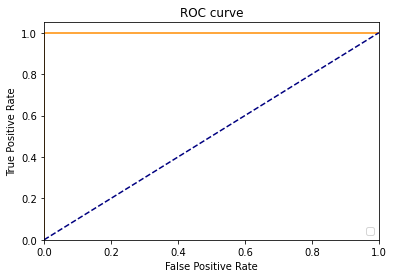

AUC score:1.0


In [34]:
plt.figure()
plt.plot(
    fpr,
    tpr,
    color="darkorange"
)
plt.plot([0, 1], [0, 1], color="navy", linestyle="--")
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC curve")
plt.legend(loc="lower right")
plt.show()
print("AUC score:"+str(auc_score))
# print("F1 score:"+str(f1_score))

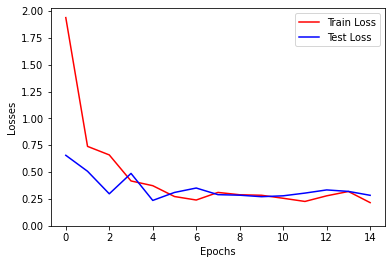

In [23]:
plt.plot(train_loss, color = 'r', label='train loss')
plt.plot(test_loss, color = 'b', label='test loss')
plt.ylim(0,)
plt.ylabel("Losses")
plt.xlabel("Epochs")
plt.legend(['Train Loss', 'Test Loss'])
plt.show()

In [ ]:
torch.save(net.state_dict(), 'model2')